In [1]:
import warnings
from collections.abc import Callable

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from desmin_reconstruction.plotting import clustered_scatterplot
from desmin_reconstruction.preprocessing.bbox import BoundingSquare, filter_bounded
from desmin_reconstruction.preprocessing.storm import (
    align_patch,
    find_optimal_clustering_angle,
)
from hdbscan import HDBSCAN
from jaxtyping import Float
from scipy.spatial.transform import Rotation
from tqdm import tqdm


df = pl.read_csv("../data/results/desmin_alphaactinin_2.5um_filtered.csv")
out = df.partition_by("probe")

points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("desmin", "actinin"))
}

In [2]:
def calibrate_tilt(
    points: Float[np.ndarray, "N 3"],
    sweep_angles: Float[np.ndarray, " N_angles"],
    sweep_angles2: Float[np.ndarray, " N_angles2"],
    *,
    degrees: bool = True,
) -> tuple[
    Callable, tuple[Float[np.ndarray, " N_angles"], Float[np.ndarray, " N_angles"]]
]:
    """Given an array of localization coordiates, sweep over the provided angle range
    to find optimal rotation angles about the y and x axes that minimizes the z range
    of the dataset."""

    def alignment_metric(z):
        z_quantiles = np.quantile(z, (0.25, 0.75))
        return z_quantiles[1] - z_quantiles[0]

    # Note that it is not that difficult to discard the dependency on scipy.spatial,
    # as 3D rotation matrices about x and y axes are quite simple.
    heights_theta = []
    for theta in tqdm(sweep_angles):
        r = Rotation.from_rotvec(theta * np.array([0, 1, 0]), degrees=degrees)
        points_rotated = r.apply(points)
        z = points_rotated[:, 2]
        heights_theta.append(alignment_metric(z))
        # heights_theta.append(np.max(z) - np.min(z))
    theta_opt = sweep_angles[np.argmin(heights_theta)]

    r1 = Rotation.from_rotvec(theta_opt * np.array([0, 1, 0]), degrees=degrees)
    points = r1.apply(points)

    heights_phi = []
    for phi in tqdm(sweep_angles):
        r = Rotation.from_rotvec(phi * np.array([1, 0, 0]), degrees=degrees)
        points_rotated = r.apply(points)
        z = points_rotated[:, 2]
        heights_phi.append(alignment_metric(z))
        # heights_phi.append(np.max(z) - np.min(z))
    phi_opt = sweep_angles[np.argmin(heights_phi)]
    r2 = Rotation.from_rotvec(phi_opt * np.array([1, 0, 0]), degrees=degrees)
    points = r1.apply(points)

    heights_gamma = []
    for gamma in tqdm(sweep_angles2):
        r = Rotation.from_rotvec(gamma * np.array([0, 0, 1]), degrees=degrees)
        points_rotated = r.apply(points)
        x = points_rotated[:, 0]
        heights_gamma.append(alignment_metric(x))
    gamma_opt = sweep_angles2[np.argmin(heights_gamma)]
    r3 = Rotation.from_rotvec(gamma_opt * np.array([0, 0, 1]), degrees=degrees)

    transform = lambda pts: r3.apply(r2.apply(r1.apply(pts)))
    return transform, (
        np.asarray(heights_theta),
        np.asarray(heights_phi),
        np.asarray(heights_gamma),
    )


In [ ]:
points_final = {k: transform(v) for k, v in points.items()}

In [2]:
df = pl.read_csv("../data/results/desmin_alphaactinin_2.5um_aligned_no_filter.csv")
out = df.partition_by("probe")

points_final = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("desmin", "actinin"))
}

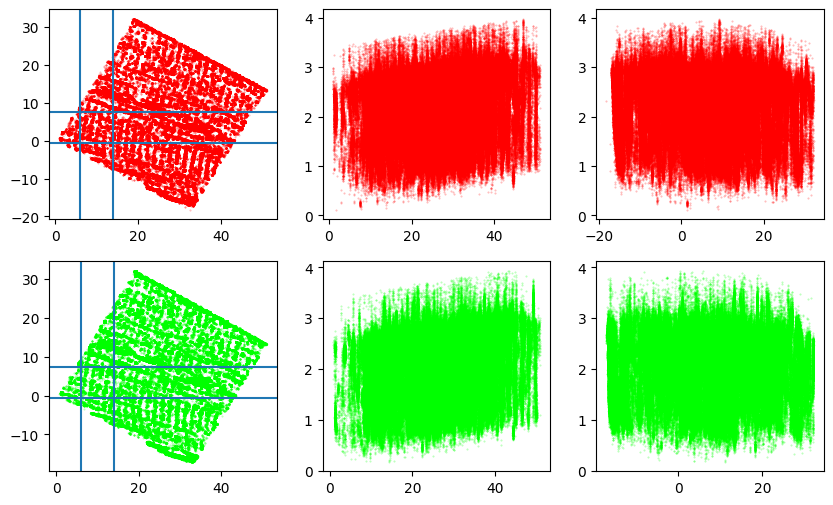

In [36]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            points_final[protein][:, ax1],
            points_final[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )
# x0s = (20,)
# y0s = (-6.5,)
bbox = BoundingSquare(6, -0.5, side=8)

for ax in axes[:, 0]:
    ax.axhline(y=bbox.y0)
    ax.axhline(y=bbox.y1)
    ax.axvline(x=bbox.x0)
    ax.axvline(x=bbox.x1)

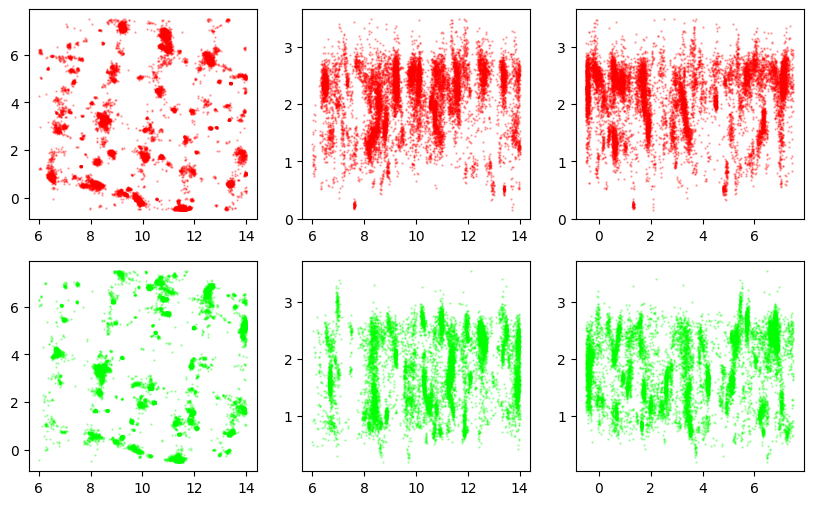

In [38]:
sq1 = {k: filter_bounded(v, bbox) for k, v in points_final.items()}

scatter_kwargs = {"alpha": 0.3, "s": 0.5}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq1[protein][:, ax1],
            sq1[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )

In [5]:
z_min = np.minimum(np.min(sq1["desmin"][:, 2]), np.min(sq1["actinin"][:, 2]))
z_max = np.maximum(np.max(sq1["desmin"][:, 2]), np.max(sq1["actinin"][:, 2]))
z_bin_edges = np.linspace(z_min, z_max, 10)
print(z_bin_edges[1] - z_bin_edges[0])

0.3767743726518411


In [ ]:
from collections import defaultdict

from ott.tools.sliced import sliced_wasserstein


wasser_dist = defaultdict(list)
pts_lowest = {k: v[v[:, 2] < z_bin_edges[1]] for k, v in sq1.items()}
for protein, pts in sq1.items():
    for j in tqdm(range(1, len(z_bin_edges) - 1)):
        idx_in_range = np.logical_and(
            pts[:, 2] >= z_bin_edges[j], pts[:, 2] < z_bin_edges[j + 1] + 1
        )
        dist = sliced_wasserstein(pts_lowest[protein], pts[idx_in_range])[0]
        wasser_dist[protein].append(dist)

100%|██████████| 8/8 [00:00<00:00, 13.74it/s]


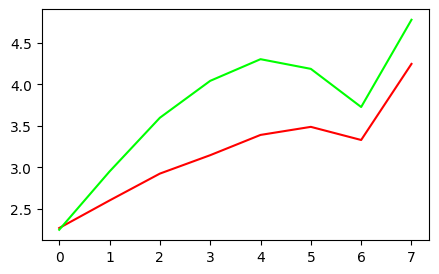

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for protein, val in wasser_dist.items():
    ax.plot(np.asarray(val), color=COLOR_DICT[protein])

In [10]:
wasser_dist

defaultdict(list,
            {'desmin': [Array(2.267393, dtype=float32),
              Array(2.5996313, dtype=float32),
              Array(2.92365, dtype=float32),
              Array(3.1457307, dtype=float32),
              Array(3.390188, dtype=float32),
              Array(3.4874768, dtype=float32),
              Array(3.3291218, dtype=float32),
              Array(4.2466946, dtype=float32)],
             'actinin': [Array(2.2463074, dtype=float32),
              Array(2.9491394, dtype=float32),
              Array(3.5970778, dtype=float32),
              Array(4.042238, dtype=float32),
              Array(4.3035326, dtype=float32),
              Array(4.186867, dtype=float32),
              Array(3.7266576, dtype=float32),
              Array(4.778812, dtype=float32)]})

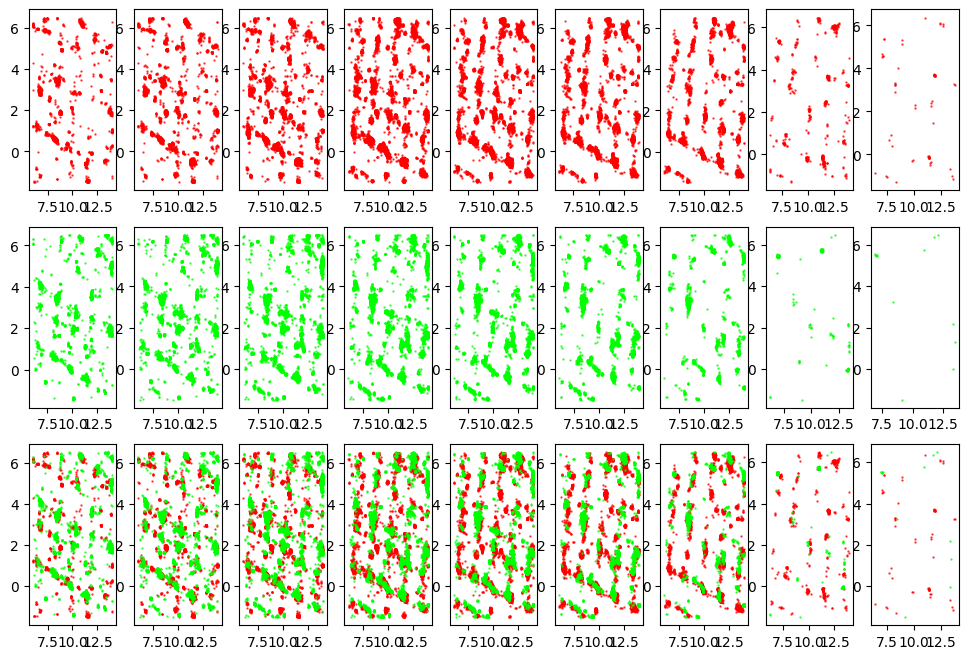

In [47]:
fig, axes = plt.subplots(3, len(z_bin_edges) - 1, figsize=(12, 8))
for i, (protein, pts) in enumerate(sq1.items()):
    for j in range(len(z_bin_edges) - 1):
        idx_in_range = np.logical_and(
            pts[:, 2] >= z_bin_edges[j], pts[:, 2] < z_bin_edges[j + 1] + 1
        )
        pts_in_range = pts[idx_in_range]
        axes[i, j].scatter(
            pts_in_range[:, 0],
            pts_in_range[:, 1],
            color=COLOR_DICT[protein],
            s=0.5,
            alpha=0.7,
        )
        axes[2, j].scatter(
            pts_in_range[:, 0],
            pts_in_range[:, 1],
            color=COLOR_DICT[protein],
            s=0.5,
            alpha=0.7,
        )

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:38<00:00, 15.82s/it]


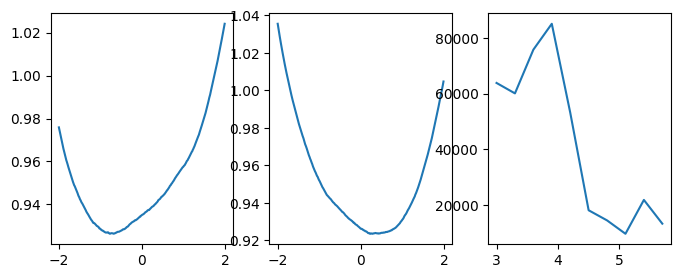

In [ ]:
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform, metrics = transform, metrics = align_patch(
        points,
        tilt_sweep_values=np.arange(-2, 2, 0.01),
        rotation_sweep_values=np.arange(3, 6, 0.3),
        min_cluster_size=1000,
        min_samples=5,
    )

fig, axes = plt.subplots(1, len(metrics), figsize=(8, 3))

for i, ax in enumerate(axes):
    ax.plot(*metrics[i])

sq2 = {k: transform(v) for k, v in sq1.items()}

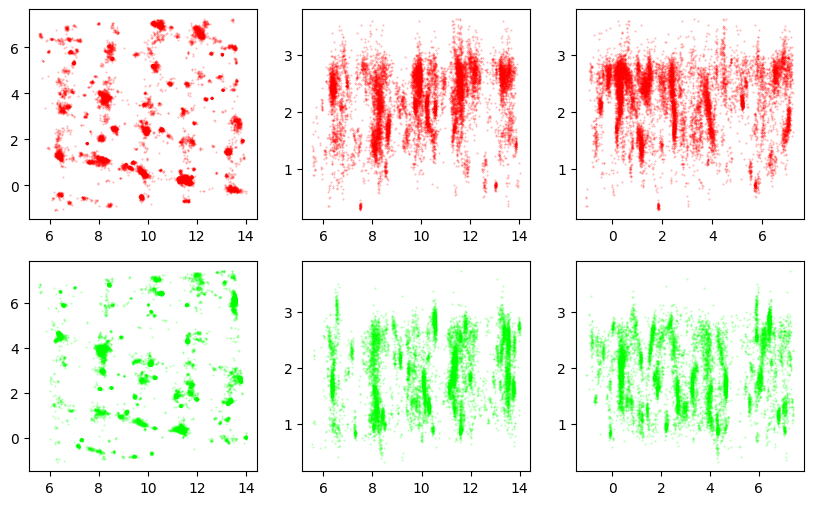

In [35]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq2[protein][:, ax1],
            sq2[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )

/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


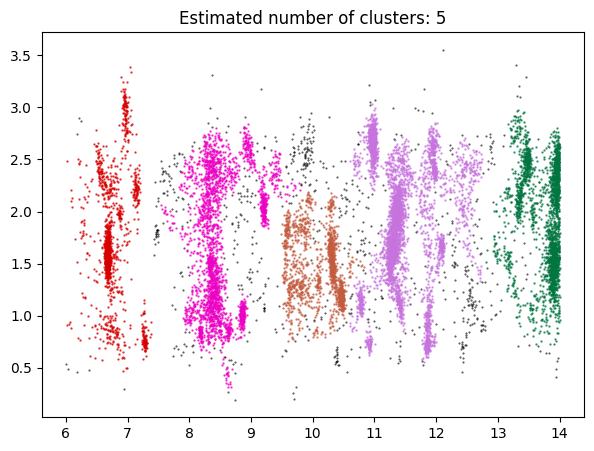

In [33]:
clusterer = HDBSCAN(min_cluster_size=1000, min_samples=5)
xz = sq1["actinin"][:, np.array([0, 2])]
clusterer.fit(xz)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax = clustered_scatterplot(ax, xz, clusterer.labels_)

In [35]:
transform, metric = find_optimal_clustering_angle(
    sq1["actinin"], np.arange(-20, 20, 0.05), min_cluster_size=1500, min_samples=1
)

  0%|          | 0/800 [00:00<?, ?it/s]/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 1/800 [00:00<03:19,  4.01it/s]/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed

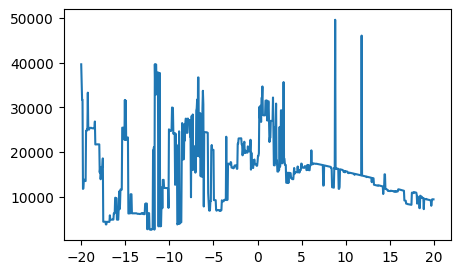

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(np.arange(-20, 20, 0.05), metric)
sq3 = {k: transform(v) for k, v in sq1.items()}

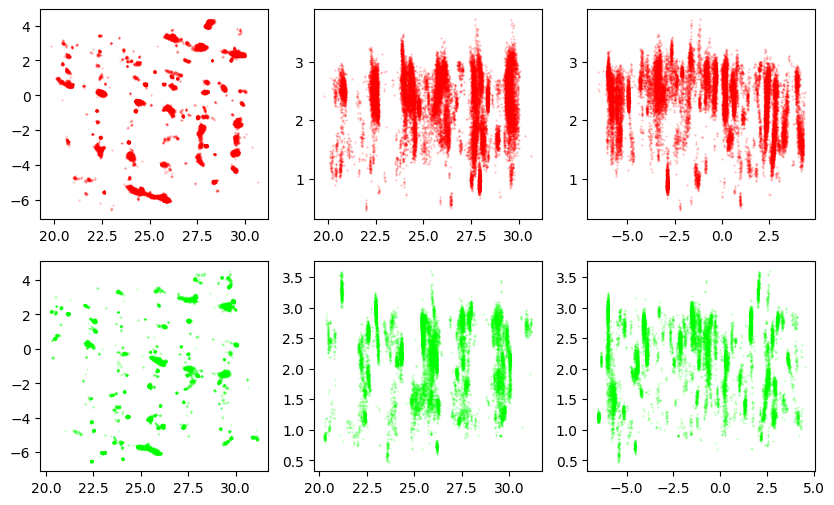

In [38]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq3[protein][:, ax1],
            sq3[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn, metrics = align_patch(
        points,
        tilt_sweep_values=np.arange(-2, 2, 0.001),
        rotation_sweep_values=np.arange(-15, 0, 0.1),
        min_cluster_size=200,
        min_samples=1,
    )

points_final = {k: transform_fn(v) for k, v in points.items()}


  5%|▍         | 7/150 [01:37<33:11, 13.93s/it]


KeyboardInterrupt: 